In [ ]:
import urllib.request
import pandas as pd
import zipfile
import numpy as np
from scipy import sparse
from collections import Counter
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

nltk.download('stopwords')

# http://help.sentiment140.com/for-students
urllib.request.urlretrieve ("http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip", "sent140.zip")

zf = zipfile.ZipFile('sent140.zip') 
Data_train = pd.read_csv(zf.open('training.1600000.processed.noemoticon.csv'), encoding='latin-1')
Data_test = pd.read_csv(zf.open('testdata.manual.2009.06.14.csv'), encoding='latin-1')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
y_train = Data_train.values[:,0]
y_test = (Data_test.values[:,0])[Data_test.values[:,0] != 2] # no neutral class

vectorizer = CountVectorizer(max_df=0.9, min_df=5,
                            max_features=600,
                            stop_words='english')
X = vectorizer.fit_transform(list(Data_train.values[:,5]) + list((Data_test.values[:,5])[Data_test.values[:,0] != 2]))
print(X.shape)
# X_split  = sparse.csr_matrix(np.array_split(X.toarray(), [(Data_train.values[:,5].shape[0])], axis=0))
X_train = X[ : Data_train.values[:,5].shape[0]]
X_test = (X[Data_train.values[:,5].shape[0] :])
print(X_train.shape)
print(X_test.shape)

print(vectorizer.get_feature_names())
classes = list(set(y_train))
X_train_C0 = X_train[y_train == classes[0]]
X_train_C1 = X_train[y_train == classes[1]]

X_train_C0_word_count = np.sum(X_train_C0, axis=0)
X_train_C1_word_count = np.sum(X_train_C1, axis=0)
tweets_C0_count = X_train_C0.shape[0]
tweets_C1_count = X_train_C1.shape[0]

(1600357, 600)
(1599999, 600)
(358, 600)
['10', '100', '11', '12', '15', '1st', '20', '30', 'able', 'account', 'actually', 'add', 'afternoon', 'ago', 'agree', 'ah', 'ahh', 'air', 'album', 'amazing', 'amp', 'anymore', 'apparently', 'aren', 'ask', 'asleep', 'ass', 'ate', 'aw', 'awake', 'awards', 'away', 'awesome', 'aww', 'awww', 'baby', 'bad', 'beach', 'beautiful', 'bed', 'believe', 'best', 'bet', 'better', 'big', 'birthday', 'bit', 'black', 'blip', 'blog', 'boo', 'book', 'bored', 'boring', 'bought', 'bout', 'boy', 'boys', 'break', 'breakfast', 'bring', 'broke', 'broken', 'brother', 'btw', 'busy', 'buy', 'bye', 'called', 'came', 'car', 'care', 'cat', 'catch', 'cause', 'chance', 'change', 'check', 'chocolate', 'church', 'city', 'class', 'clean', 'cleaning', 'close', 'coffee', 'cold', 'college', 'com', 'come', 'comes', 'coming', 'computer', 'concert', 'congrats', 'cool', 'couldn', 'couple', 'course', 'crap', 'crazy', 'cream', 'cut', 'cute', 'cuz', 'da', 'dad', 'damn', 'dance', 'date', 'day

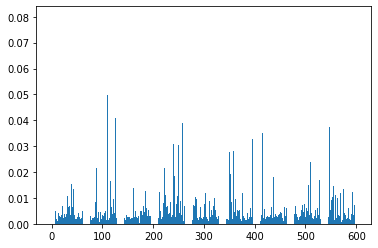

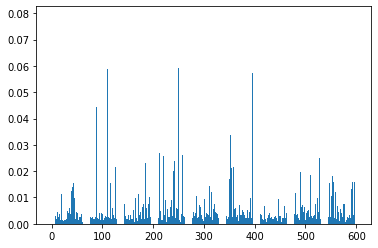

In [ ]:
# P(xj = 1 | y = c, theta_jc) = P(word = 1 | class, theta_jc) = No of word occurance / No of documents = theta_MLE_j -> Murphy at al
prob_MLE_word_given_tweets_C0 = np.exp(np.log(X_train_C0_word_count) - np.log(tweets_C0_count))
prob_MLE_word_given_tweets_C1 = np.exp(np.log(X_train_C1_word_count) - np.log(tweets_C1_count))
word_no = list(range(prob_MLE_word_given_tweets_C0.shape[1]))
plt.bar(word_no, prob_MLE_word_given_tweets_C0.tolist()[0])
plt.show()
plt.bar(word_no, prob_MLE_word_given_tweets_C1.tolist()[0])
plt.show()

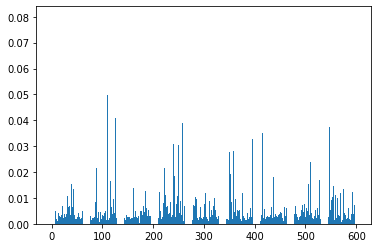

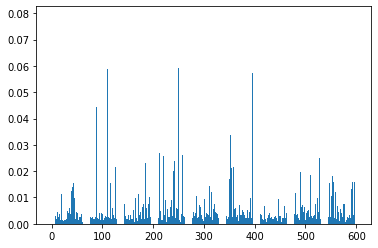

In [ ]:
# Bayesian Word Probability
# P(theta_jc | data) = P(theta_jc | xj = 1, y = c)
# P(theta_jc | data) = P(xj = 1 | y = c, theta_jc) * P(theta_jc) / P(xj)
# P(theta_jc | data) = Ber(xj=1 | y=c, theta_jc) * Beta(beta1, beta2) / P(xj)
# P(theta_jc | data) = Beta(beta1 + N_jc, beta2 + Nc - N_jc)
# theta_jc_MAP = (beta1 + N_jc) / (beta1 + beta2 + Nc)
# uninformed (uniform) conjugate prior for bernoulli word model is a beta distribution
beta1, beta2 = 1, 1
prob_mean_word_given_tweets_C0 = np.exp(np.log(X_train_C0_word_count + beta1) - np.log(tweets_C0_count + beta1 + beta2))
prob_mean_word_given_tweets_C1 = np.exp(np.log(X_train_C1_word_count + beta1) - np.log(tweets_C1_count + beta1 + beta2))
word_no = list(range(prob_mean_word_given_tweets_C0.shape[1]))
plt.bar(word_no, prob_mean_word_given_tweets_C0.tolist()[0])
plt.show()
plt.bar(word_no, prob_mean_word_given_tweets_C1.tolist()[0])
plt.show()

In [ ]:
# posterior predictive distribution -> Murphy at al
# P(y = c | data) = P(y=c | data) * P(x_i | y=c, data) / P(x_i)
# P(y = c | data) = P(y=c | data) * PRODUCT_j[ P(x_j | y=c, data) ] / P(x_i)
# P(y = c | data) = SUM_pi_c[ P(y=c | pi_c) * P(pi_c | data) ] * SUM_theta_jc[ PRODUCT_j(P(x_j | theta_jc) P(theta_jc | y=c, data) ] / P(x_i)
# P(y = c | data) = SUM_pi_c[ Cat(y=c | pi_c) * Dir(N_c0 + alpha1, N_c1 + alpha2) ] * SUM_theta_jc[ PRODUCT_j(P(x_j | theta_jc) P(theta_jc | y=c, data) ] / P(x_i)
# P(y = c | data) ∝ E[pi_c | data] * PRODUCT_j[ E[theta_jc | data]^I[x_j=1] * (1 - E[theta_jc | data])^I[x_j=1] ]
# P(y = c | data) ∝ pi_c_mean *  PRODUCT_j[ theta_jc_mean^I[x_j=1] * (1 - theta_jc_mean)^I[x_j=1] ]
# -> pi_c_mean = (N_c + alpha_c) / (N_c0 + N_c1 + alpha_c0 + alpha_c1)
# -> theta_jc_mean = (N_jc + beta0) / (N_c + beta0)

# mean Estimate of classes
# uninformed categorical prior for is dirichlet but in this case since it's only two classes Beta again

prob_mean_C0 = (beta1 + tweets_C0_count) / (beta1 + beta2 + tweets_C0_count + tweets_C1_count)
prob_mean_C1 = (beta2 + tweets_C1_count) / (beta1 + beta2 + tweets_C0_count + tweets_C1_count)


# invert one's and zero's and make them negative [0 1 0] -> [1 0 1]
X_test_invert = ((X_test != 1) * (1))
print(prob_mean_word_given_tweets_C0.T.shape)
print(type(prob_mean_word_given_tweets_C0))
print(X_test.shape)
print(type(X_test))
print(X_test_invert.shape)
# print(X_test)
# if word not existend, fill negative probability add ones [-1 0 -1] -> [(1-theta_1)  0  (1-theta_3) ]
prob_words_masked_C0 = (np.multiply(X_test_invert.A, prob_mean_word_given_tweets_C0) *(-1) + X_test_invert.A) + (np.multiply(prob_mean_word_given_tweets_C0, X_test.A))
prob_words_masked_C1 = (np.multiply(X_test_invert.A, prob_mean_word_given_tweets_C1) *(-1) + X_test_invert.A) + (np.multiply(prob_mean_word_given_tweets_C1, X_test.A))

# Log odds has some advantages 
# it shows if above 1 it blongs to numerator class and, if below 1 it belongs to denominator class
# additionally the computationally costly integral of the bayes formula cancels out
log_odds = (np.log(prob_mean_C1) + np.nansum(np.log(prob_words_masked_C0), axis=1)) \
                - (np.log(prob_mean_C0) + np.nansum(np.log(prob_words_masked_C1), axis=1))

(600, 1)
<class 'numpy.matrix'>
(358, 600)
<class 'scipy.sparse.csr.csr_matrix'>
(358, 600)


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: SparseEfficiencyWarning: Comparing a sparse matrix with a nonzero scalar using != is inefficient, try using == instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
# log-odds = 1 means equal probability of each class, therefore it's the separation line between classes 
y_pred = ((log_odds < 1)*4).T[0]
correct_class = ((y_pred == y_test)*1)
accuracy =  np.sum(correct_class)/ correct_class.shape[1]

print("Prediction Accuracy =", accuracy)

Prediction Accuracy = 0.6899441340782123


In [ ]:
# Future Outlook: There are better language models than this. The goal was just to use a Dirichlet Prior